## Benchmark model
Note: this research presents preliminary findings and is being distributed to interested readers solely to stimulate discussion and elicit comments. The benchmark model is used to better understand feature importances, primary metrics and performance of Azure `AutoML` models and `HyperDrive` tuning options.

In [3]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve 
from sklearn.metrics import plot_precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, matthews_corrcoef
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
%matplotlib inline
from IPython.display import Image
display.mpl_style ='ggplot'


#from helpers import clean_data, load_data

## 0. Introduction
The primary objective is to develop an early warning system, i.e. binary classification failed (1) vs. healthy (0), for regulated banks using their quarterly filings with the FDIC. There was a significant increase in the number of failing banks during from 2009 and 2014.

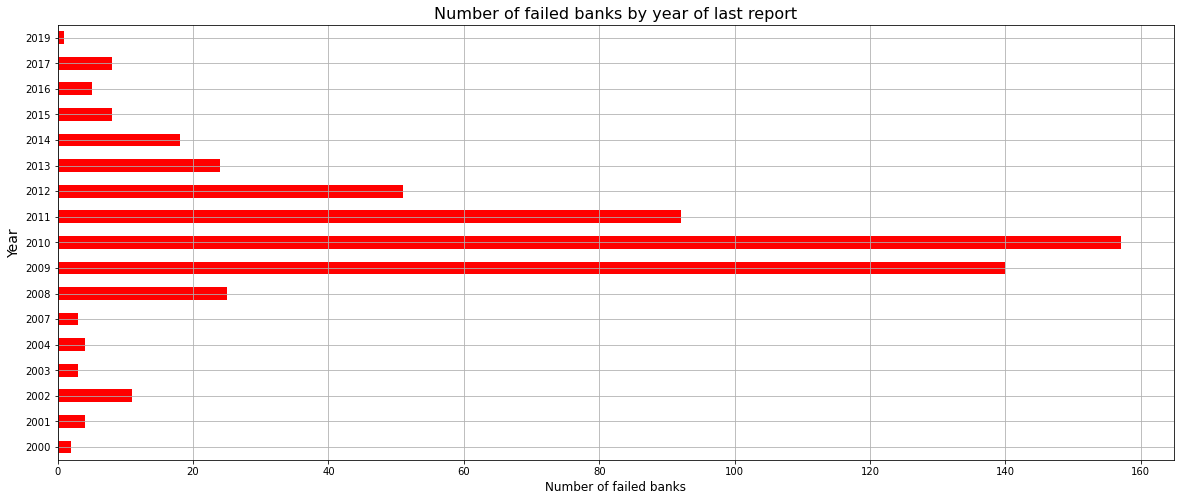

In [579]:
failed_banks = pd.read_csv('data/failed_banks_dataset.csv')
failed_banks['Date'] = pd.to_datetime(failed_banks['Closing Date'])
failed_banks['Year_failed'] = failed_banks['Date'].dt.year
failed_banks['Quarter_failed'] = failed_banks['Date'].dt.quarter
ax = failed_banks.groupby(failed_banks.Date.dt.year)['Bank Name'].count().plot(
    kind='barh', color='r', figsize=(20, 8))
ax.grid()
ax.set_xlabel("Number of failed banks", fontsize=12)
ax.set_ylabel("Year", fontsize=14)
plt.title(label ="Number of failed banks by year of last report", fontsize=16)
plt.show()

Overall, 137 failed banks and 6,877 surviving banks were used for the modeling. Historical data from the first 8 quarters ending in 2010Q3 (`./data`) is used to train the model and out-of-sample testing is performed on quarterly data starting from 2012Q4 (`./oos`).  For more information on methodology please view `CAMELS.md` file included in the repository.

#### CALL reports empirical data 
Approximately 2,000 preliminary features were obtained for every bank instance from "Report of Condition and Income" (CALL report) using publicly available SOAP APIs. Eventually, only 14 features were used for classification. For more information please visit https://www.investopedia.com/terms/c/callreport.asp

In [580]:
# Import banks universe surviving after 2010Q3
universe = pd.read_csv('data/reduced_universe_after2010Q3.csv', index_col=0)

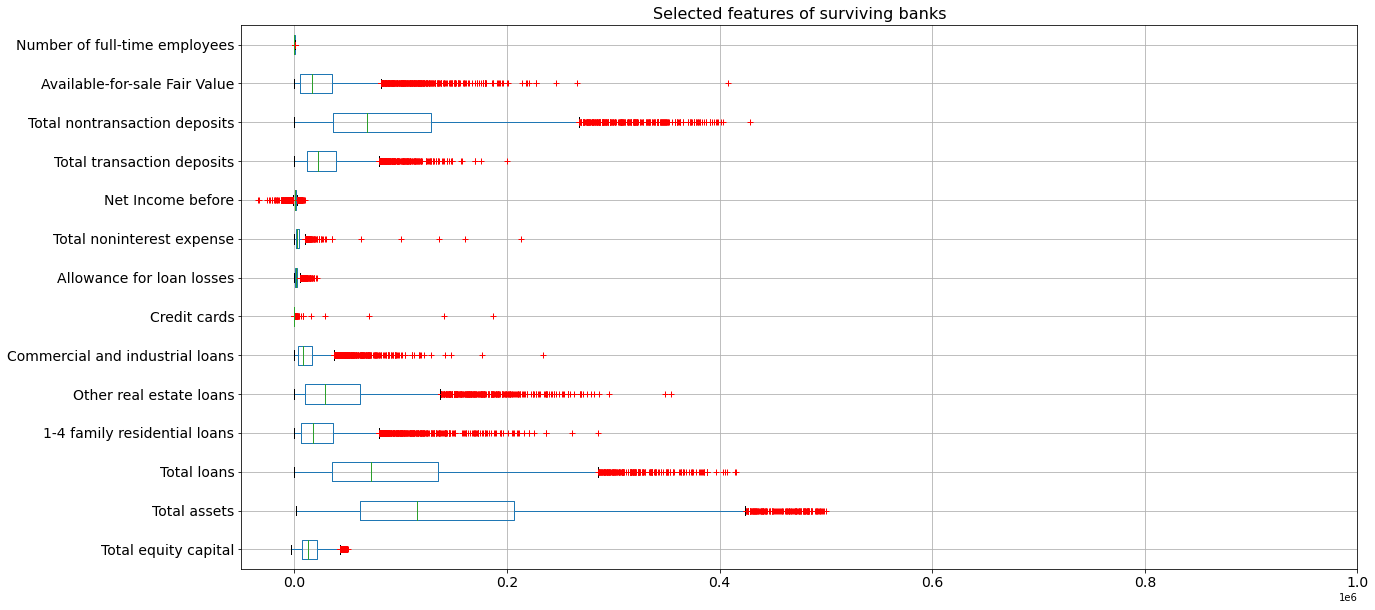

In [581]:
# Features of surving banks
surviving_universe = universe.loc[universe['Target']==0]
surviving_universe.pop('Target')
surviving_universe.boxplot(figsize=(20,10), vert=False, sym='r+', fontsize=14).set_xlim(-50000, 1000000)
plt.title(label ="Selected features of surviving banks", fontsize=16)
plt.show()

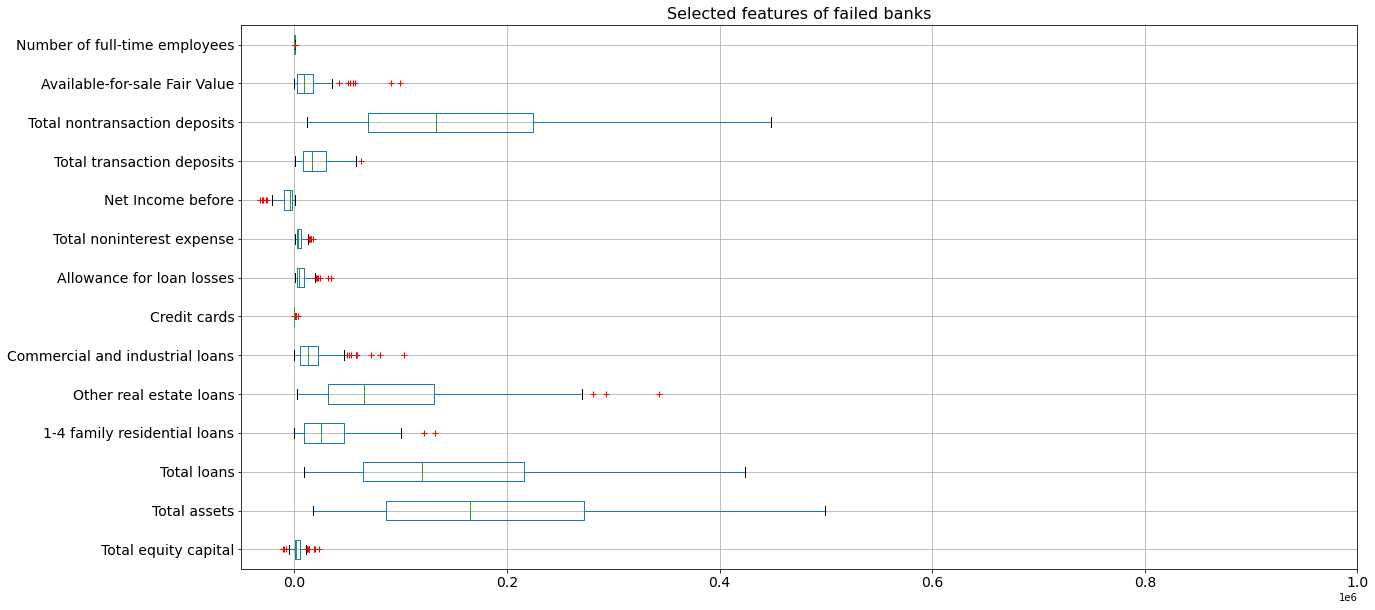

In [582]:
# Features of failed banks
failed_universe = universe.loc[universe['Target']==1]
failed_universe.pop('Target')
failed_universe.boxplot(figsize=(20,10), vert=False, sym='r+', fontsize=14).set_xlim(-50000, 1000000)
plt.title(label ="Selected features of failed banks", fontsize=16)
plt.show()

#### CAMELS featurization 
Selected financial ratios listed above were used to produce unique risk profiles according to CAMELS valuation framework. This framework is used to assess performance along 6 risk dimensions, namely Capital, Assets, Management, Earnings, Liquidity, and Sensitivity to market risk, hence the abbreviation. For more information please visit https://en.wikipedia.org/wiki/CAMELS_rating_system
1. **Capital** adequace will be measure by 
        - 'EQTA' = Total Equity / Total Assets
        - 'EQTL' = Total Equity / Total Loans
2. **Assets** quality will be measure by 
        - 'NPLTA' = Non Performing Loans / Total Assets
        - 'NPLGL' = Non Performing Loans / Gross Loans
        - 'LLRTA' = Loan Loss Reserves / Total Assets
        - 'LLRGL' = Loan Loss Reserves / Gross Loans
3. **Management** quality will be measure by 
        - 'OCNOI' = Operating Costs / Net Operating Income
        - 'OEXTA' = Operating Expenses / Assets
4. **Earnings** ability will be measure by 
        - 'ROA' = Net Income / Total Assets
        - 'ROE' = Net Income / Total Equity
5. **Liquidity**, ability to fulfill its short-term liability, will be measure by 
        - 'TLTD' = Total Loans / Total Customer Deposits
        - 'TDTA' = Total Customer Deposits / Total Assets
6. **Sensitivity** to market risk will be measure by 
        - 'TINOI = Trading Income / Net Operating Income

Below is stylized representation of bank's risk profile using CAMELS risk dimensions:

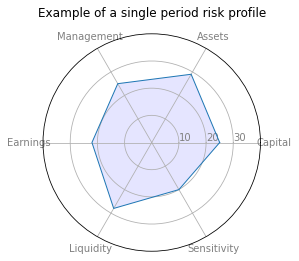

In [623]:
camels_df = pd.DataFrame({'group': ['A','B','C','D'],
                          'Capital': [25, 1.5, 30, 4],
                          'Assets': [29, 10, 9, 34],
                          'Management': [25, 39, 23, 24],
                          'Earnings': [22, 31, 33, 14],
                          'Liquidity': [28, 15, 32, 14],
                          'Sensitivity': [20, 10, 10, 10]})
 
categories=list(camels_df)[1:]
N = len(categories)
values=camels_df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=10)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=10)
plt.ylim(0,40)

ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, 'b', alpha=0.1)
plt.title("Example of a single period risk profile")
plt.show()

## 1. Preprocessing

In [2]:
file_path = "data/camel_data_after2010Q3.csv"

In [3]:
df = load_data(file_path)

Show the features of failed banks (Target of 1) and count them

In [4]:
df.loc[df.Target == 1].count()

AsOfDate    137
Target      137
EQTA        137
EQTL        137
LLRTA       137
LLRGL       137
OEXTA       137
INCEMP      137
ROA         137
ROE         137
TDTL        137
TDTA        137
TATA        137
dtype: int64

Show the features of surviving banks (Target of 0) and count them

In [5]:
df.loc[df.Target == 0].count()

AsOfDate    6883
Target      6883
EQTA        6883
EQTL        6883
LLRTA       6883
LLRGL       6883
OEXTA       6883
INCEMP      6877
ROA         6883
ROE         6883
TDTL        6883
TDTA        6883
TATA        6883
dtype: int64

### 1.2 Class Imbalances (check with SMOTE or Cost-Sensitive Learning)
**https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23**

In [ ]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',                                                  np.unique(y_train), y_train)
# model.fit(X_train, y_train, class_weight=class_weights)

### 1.3 Compare Using Logistic Regression Feautres (ELI5, LIME, SHAP)
**https://www.youtube.com/watch?v=C80SQe16Rao**

## 2. Developing basic Gradient Boosting Classifier 

First train/test split, note `random_state=123` for the auditing purposes.

In [6]:
X, y = clean_data(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

Creating `StandardScaler` object and fitting, i.e. removing the mean and scaling to unit variance.

In [8]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

Transforming training and testing features data using the fitted scaler.

In [9]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## 3. Optimizing with `GridSearch`
The cell below takes significant time to run, around 15 minutes on some machines.

#### 3.1. Optimizing AUC 
The cell below takes significant time to run, around 15 minutes on some machines.

In [ ]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9], 
             "n_estimators" : [20, 30, 40, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4, 5]} 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = 'roc_auc', cv=5)
grid.fit(X, y.ravel());
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 2, 'n_estimators': 30}

#### 3.2 Optimizing Sensitivity (Minimizing Type II Error)
The cell below takes significant time to run, around 15 minutes on some machines.

In [118]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9], 
             "n_estimators" : [20, 30, 40, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4, 5]} 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = 'recall', cv=5)
grid.fit(X, y.ravel());
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 5, 'n_estimators': 20}

Take note of these parameters listed below:

    `{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 5, 'n_estimators': 20}`

Take note of the following evaluation metrics:
- Accuracy: (TP + TN)/(TP + TN + FP + FN)
- Misclassification Rate: 1 - Accuracy or (FP + FN)/(TP + TN + FP + FN)
- Sensitivity (Recall or True Positive Rate): TP / (TP + FN)
- Specificity: TN / (TN + FN)
- False Positive Rate: FP / (TN + FP)
- Precision: TP / (TP + FP)

## 4. Evaluating the best model
At least include 
 - (1) the confusion matrix, 
 - (2) binary classification metrics, 
         -(1) precision, (2) recall, (3) F1 score (Also, G-mean, first being the precision-recall g-mean, and the second being the sensitivity-specificity g-mean), (4) accuracy, and (5) specificity. Also to possibly consider, balanced accuracy, Matthews correlation coefficient, markedness, and informednes
 - (3) the receiver operating characteristic curve, and 
 - (4) the precision-recall curve.

In [13]:
clf_best = GradientBoostingClassifier(verbose=3, 
                                      n_estimators=20,
                                      learning_rate=0.1,
                                      max_features=5,
                                      max_depth=2,
                                      random_state=123)

clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
print("Testing accuracy: {0:.3f}%".format(accuracy_score(predictions, y_test) * 100 ))

      Iter       Train Loss   Remaining Time 
         1           0.1007            0.21s
         2           0.0936            0.15s
         3           0.0844            0.13s
         4           0.0808            0.11s
         5           0.0770            0.10s
         6           0.0736            0.10s
         7           0.0694            0.10s
         8           0.0661            0.09s
         9           0.0621            0.08s
        10           0.0595            0.07s
        11           0.0570            0.06s
        12           0.0547            0.06s
        13           0.0534            0.05s
        14           0.0511            0.04s
        15           0.0493            0.03s
        16           0.0478            0.03s
        17           0.0462            0.02s
        18           0.0453            0.01s
        19           0.0440            0.01s
        20           0.0425            0.00s
Testing accuracy: 98.812%


#### Visual representation of one possible pass with Tree

In [45]:
clf_tree = DecisionTreeClassifier(random_state=123)
clf_tree.fit(X_train_scaled, y_train)


DecisionTreeClassifier(random_state=123)

In [19]:
text_representation = tree.export_text(clf_tree)
print(text_representation)

|--- feature_1 <= -0.02
|   |--- feature_4 <= -0.25
|   |   |--- class: 1
|   |--- feature_4 >  -0.25
|   |   |--- feature_5 <= -0.19
|   |   |   |--- feature_1 <= -0.02
|   |   |   |   |--- feature_6 <= -2.31
|   |   |   |   |   |--- feature_4 <= 0.73
|   |   |   |   |   |   |--- feature_2 <= 5.84
|   |   |   |   |   |   |   |--- feature_0 <= -1.92
|   |   |   |   |   |   |   |   |--- feature_9 <= 1.46
|   |   |   |   |   |   |   |   |   |--- feature_4 <= -0.05
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_4 >  -0.05
|   |   |   |   |   |   |   |   |   |   |--- feature_5 <= -0.22
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- feature_5 >  -0.22
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_9 >  1.46
|   |   |   |   |   |   |   |   |   |--- feature_3 <= -0.01
|   |   |   |   |   |   |   |   |   |   |

Cell below is only used to store the tree in current directory, commented out for the final:

In [596]:
# with open("decistion_tree.log", "w") as fout:
#     fout.write(text_representation)

#### Class imbalances 
Check for Null Accuracy, i.e. always predicting majority class. Start with class distribution below:

In [14]:
y_true = pd.DataFrame(y_test, columns=['y_true'])
y_true["y_true"].value_counts()

0    2070
1      35
Name: y_true, dtype: int64

In [15]:
print('Calculate the percentage of ones: {0:.3f}%'.format(y_true["y_true"].mean() * 100))

Calculate the percentage of ones: 1.663%


In [16]:
print('Calculate Null accuracy for binary classification: {0:.3f}%'.format(
    max(y_true["y_true"].mean(), 1 - y_true["y_true"].mean()) *100))

Calculate Null accuracy for binary classification: 98.337%


#### Model Performance over Thresholds
The precision-recall curve plots the relationship between precision and recall as the decision threshold changes. Recall is the ability of a model to detect all positive samples and precision is the ability of a model to avoid labeling negative samples as positive. Some business problems might require higher recall and some higher precision depending on the relative importance of avoiding false negatives vs false positives. 

Source: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#precision-recall-curve

2-class Precision-Recall curve: Avg. Precision=0.63


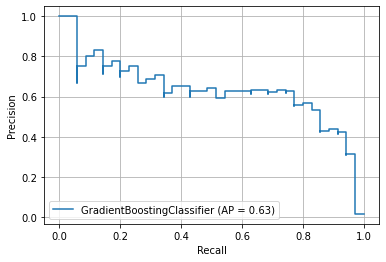

In [17]:
y_score = clf_best.decision_function(X_test_scaled)
average_precision = average_precision_score(y_test, y_score)
disp = plot_precision_recall_curve(clf_best, X_test_scaled, y_test)
print('2-class Precision-Recall curve: Avg. Precision={0:0.2f}'.format(average_precision))
plt.grid(True)

The receiver operating characteristic (ROC) curve plots the relationship between true positive rate (TPR) and false positive rate (FPR) as the decision threshold changes. The area under the curve (AUC) can be interpreted as the proportion of correctly classified samples. More precisely, the AUC is the probability that the classifier ranks a randomly chosen positive sample higher than a randomly chosen negative sample. The shape of the curve gives an intuition for relationship between TPR and FPR as a function of the classification threshold or decision boundary. 

Source: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#roc-curve

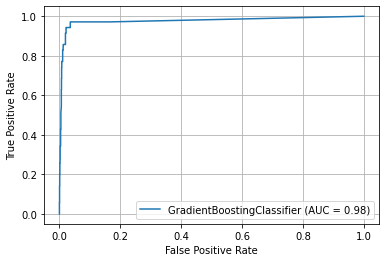

In [18]:
from sklearn.metrics import plot_roc_curve
clf_best_disp = plot_roc_curve(clf_best, X_test_scaled, y_test)
plt.grid(True)
plt.show()

#### Generate confusion matrix

In [19]:
pd.DataFrame(confusion_matrix(y_test, predictions), index=["Actual 0", "Actual 1"], 
             columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
True 0,2056,14
True 1,11,24


In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
tn, fp, fn, tp

(2056, 14, 11, 24)

In [21]:
print("recall: {0:.5f}".format(tp/(tp+fn)))
print("precision: {0:.5f}".format(tp/(tp+fp))) #TP / (TP + FP)

recall: 0.68571
precision: 0.63158


#### Compute Matthews correlation

In [22]:
matthews_corrcoef(y_test, predictions)
print("Matthews Correlation is {0:.3f}".format(matthews_corrcoef(y_test, predictions)))

Matthews Correlation is 0.652


#### Generate classification report

In [23]:
print("In-Sample Classification Report")
print(classification_report(y_test, predictions))

In-Sample Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2070
           1       0.63      0.69      0.66        35

    accuracy                           0.99      2105
   macro avg       0.81      0.84      0.83      2105
weighted avg       0.99      0.99      0.99      2105



## 5. Analysing rules that were learned in training

#### Extracting rules and feature importances 

In [24]:
n_classes, n_estimators = clf_best.estimators_.shape

for c in range(n_classes):
    
    for t in range(n_estimators):
        
        dtree = clf_best.estimators_[c, t]
        rules_df = pd.DataFrame({
            'child_left': dtree.tree_.children_left,
            'child_right': dtree.tree_.children_right,
            'feature': dtree.tree_.feature,
            'threshold': dtree.tree_.threshold,
        })
rules_df.head()

,child_left,child_right,feature,threshold
0,1,4,0,-1.059494
1,2,3,4,-0.330532
2,-1,-1,-2,-2.000000
3,-1,-1,-2,-2.000000
4,5,6,4,2.426574


#### Predicting probabilities of instance being in a class

In [25]:
instance = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
probs = clf_best.predict_proba(instance).ravel()
classes = clf_best.classes_
print('Predicted prob for class {} is {:.3f}, and for class {} is {:.3f}'.format(
    classes[0], probs[0], classes[1], probs[1]))

Predicted prob for class 0 is 0.996, and for class 1 is 0.004


In [26]:
clf_best.predict_proba(instance)

array([[0.995921, 0.004079]])

## 6. Out-of-sample GBM testing 

In [27]:
insample_results = {
    '2009Q4':{'Actually failed':31, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63},
    '2010Q1':{'Actually failed':35, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63},
    '2010Q2':{'Actually failed':41, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63}, 
    '2010Q3':{'Actually failed':30, 'Predicted fail':0, 'Recall (TP/TP+FN)':0.69, 'Precision (TP/TP+FP)':0.63}}
results_df = pd.DataFrame.from_dict(insample_results, orient='index')
results_df

,Actually failed,Predicted fail,Recall (TP/TP+FN),Precision (TP/TP+FP)
2009Q4,31,0,0.69,0.63
2010Q1,35,0,0.69,0.63
2010Q2,41,0,0.69,0.63
2010Q3,30,0,0.69,0.63


In [28]:
pd.set_option('use_inf_as_na', True)
oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4']
outofsample_results = {}

for report in oos_reports:
    
    oos_df = pd.read_csv('oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos) 
    
    predictions_oos = clf_best.predict(X_oos_scaled)
    tn, fp, fn, tp = confusion_matrix(y_oos, predictions_oos).ravel()
    mcc = np.round(matthews_corrcoef(y_oos, predictions_oos), 2)
    
    outofsample_results[report] = {'Actually failed':fn+tp, 
                                   'Predicted fail':tp,
                                   'Recall (TP/TP+FN)':np.round(tp/(tp+fn), 2),
                                   'Precision (TP/TP+FP)':np.round(tp/(tp+fp), 2)
                                  } #Precision: TP / (TP + FP)
    
    # Generate out-of-sample MCC and classification report 
    print("*" * 55, "\nMatthews Correlation (MCC) for {} is {}".format(report, mcc))
    print("*" * 55,"\nOut-of-sample (OOS) Classification Report for {}:".format(report))
    print(classification_report(y_oos, predictions_oos), "\n\n")

******************************************************* 
Matthews Correlation (MCC) for 2010Q4 is 0.66
******************************************************* 
Out-of-sample (OOS) Classification Report for 2010Q4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6779
           1       0.53      0.83      0.65        24

    accuracy                           1.00      6803
   macro avg       0.76      0.92      0.82      6803
weighted avg       1.00      1.00      1.00      6803
 


******************************************************* 
Matthews Correlation (MCC) for 2011Q1 is 0.48
******************************************************* 
Out-of-sample (OOS) Classification Report for 2011Q1:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6713
           1       0.23      1.00      0.38        19

    accuracy                           0.99      6732
   macro avg       0.62 

The results from out-of-sample testing above are represented on a summary plot below

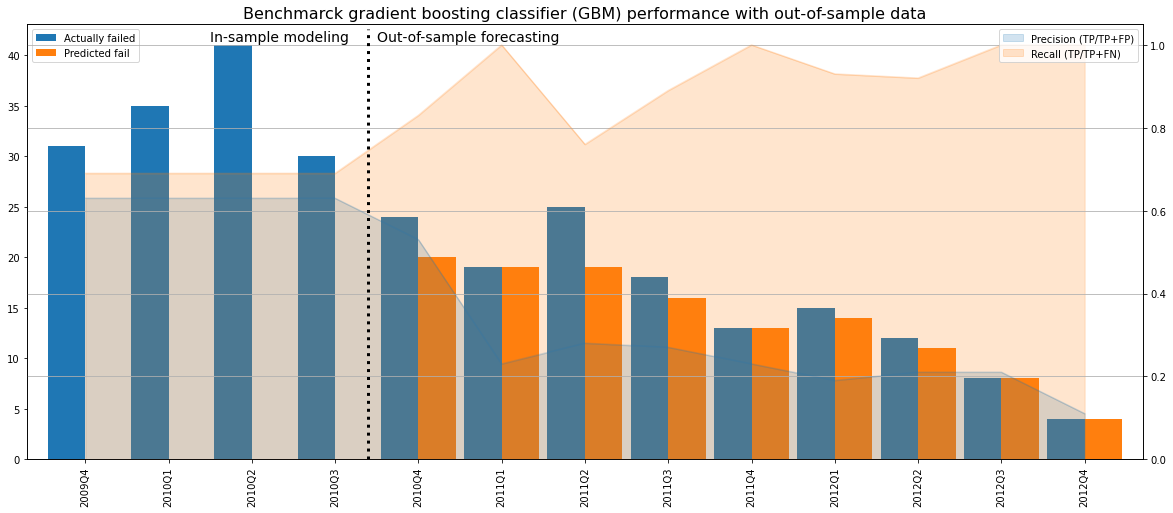

In [29]:
# Combine all statistic in one df, this inludes in- and out-of sample results
results_plot_df = results_df.append(pd.DataFrame.from_dict(outofsample_results).T)

# Prepare figure object and split axes
fig, ax1 = plt.subplots(sharex=True, figsize=(20, 8))
ax2 = ax1.twinx()

# Plot actual and predicted counts as bars on the left axis
results_plot_df[['Actually failed','Predicted fail']].plot(
    kind='bar', ax=ax1, width=0.9).legend(loc='upper left')                                                              

# Plot precision and recall scores as lines or areas on the right axis
results_plot_df[['Precision (TP/TP+FP)', 'Recall (TP/TP+FN)']].plot(
    kind='area', stacked=False, alpha=0.2, ax=ax2).legend(loc='upper right')
plt.axvline(x=3.4, ymin=0, ymax = 0.99, linewidth=3, color='k', linestyle=':')

# Organize elements of the plot
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.grid(True)

# Manage text boxes here, location and content
ax1.text(x= 1.5, y=42.5, s='In-sample modeling', fontsize=14, verticalalignment='top')
ax1.text(x= 3.5, y=42.5, s='Out-of-sample forecasting', fontsize=14, verticalalignment='top')
plt.title('Benchmarck gradient boosting classifier (GBM) performance with out-of-sample data', fontsize=16)

plt.show()

-- end --